In [3]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist

import tyxe

/home/riccardo/anaconda3/envs/bayesian/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


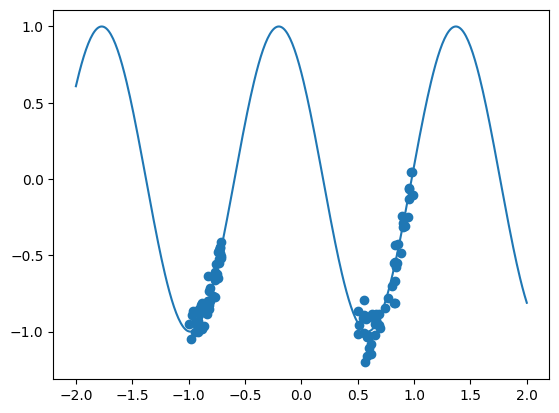

In [4]:
pyro.set_rng_seed(42)
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(50, 1) * 0.5 + 0.5
x = torch.cat([x1, x2])
y = x.mul(4).add(0.8).cos() + 0.1 * torch.randn_like(x)

x_test = torch.linspace(-2, 2, 401).unsqueeze(-1)
y_test = x_test.mul(4).add(0.8).cos()
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))
plt.scatter(x.squeeze(), y)
plt.plot(x_test.squeeze(), y_test)

In [8]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x), positive_scale=False)
guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide)

In [9]:
obs_model

HeteroskedasticGaussian()

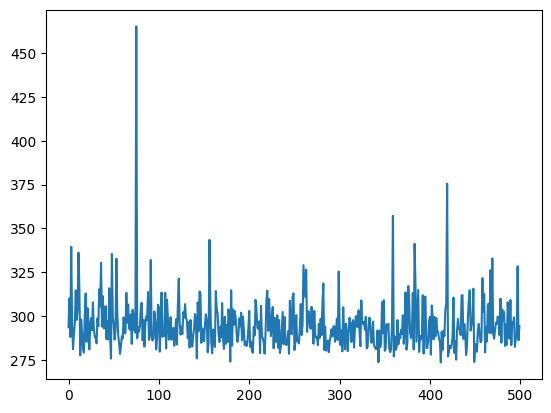

In [12]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    elbos.append(e)
    
with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 500, callback)
plt.plot(elbos)

In [24]:
pred = bnn.predict(x_test, num_predictions=32)

In [26]:
pred[0]

tensor([-1.2489, -0.1909])

In [27]:
y[0]

tensor([-0.4760])